# Аналитика в Яндекс.Афише

Мы были приглашены на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Нужно изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Для начала импортируем библиотеки, которые могут нам понадобится.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st
from scipy.stats import ttest_ind
import seaborn as sns
import decimal

##  Шаг 1. Загрузка  и подготовка данных к анализу.

Нам для анализа предоставлены три файла:

- visit_logs - лог сервера с данными о посещениях сайта Яндекс.Афиши.
- orders_logs - выгрузка заказов за период с июня 2017 по конец мая 2018 года.
- costs - статистика рекламных расходов.

Загрузим эти файлы в соответствующие переменные.

<font color=#008000> 1.1 Загрузка и сохранение файлов в переменных </font>

Загрузим эти файлы в соответствующие переменные.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

<font color=#008000> 1.2 Предобработка данных </font>

Внимательно посмотрим на таблицу 'visits'.

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропусков нет. В колонках с датами End_Ts и Start_Ts данные имеют тип object. Нужно перевести их в datetime. Также изменим названия колонок 'End Ts', 'Source Id', 'Start Ts'.

In [5]:
visits.set_axis(['device', 'session_end', 'source_id', 'session_start', 'uid'], axis = 'columns', inplace = True)

In [6]:
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

In [7]:
visits.head()

,device,session_end,source_id,session_start,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null datetime64[ns]
source_id        359400 non-null int64
session_start    359400 non-null datetime64[ns]
uid              359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Теперь посмотрим на данные в колонке 'orders'.

In [9]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Пропусков нет. В колонке 'Buy_Ts' даты данные приняли тип 'object'. Переведём его в datetime. Также изменим названия колонок.

In [11]:
orders.set_axis(['purchase_date', 'revenue', 'uid'], axis = 'columns', inplace = True)

In [12]:
orders['purchase_date'] = pd.to_datetime(orders['purchase_date'])

In [13]:
orders.head()

,purchase_date,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
purchase_date    50415 non-null datetime64[ns]
revenue          50415 non-null float64
uid              50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


На очереди - данные из таблицы costs.

In [15]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропусков также нет. Данные в колонке dt нужно перевести в datetime, а названия колдонок изменить.

In [17]:
costs.set_axis(['source_id', 'date', 'costs'], axis = 'columns', inplace = True)

In [18]:
costs['date'] = pd.to_datetime(costs['date'])

In [19]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


###### Вывод

Мы осмотрели данные в колонках visits, orders и costs, и предприняли следующие шаги по предобработке:

- перевод данных в колонках с датами и временем из object в datetime.
- изменение названий колонок на более понятные.


##  Шаг 2. Отчёты и метрики.

<font color=#008000> 2.1 Сколько людей пользуются в день, неделю, месяц? </font>

Нам нужно изучить пользовательскую активность. Для этого найдем следующие метрики:

- DAU (от англ. daily active users) — количество уникальных пользователей в день
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц

Для начала добавим в таблицу 'visits' колонки с месяцем, неделей, и днём.

In [21]:
visits['session_year']  = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week']  = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

Теперь подсчитаем метрики, сгруппировав по уникальным пользователям, и посчитав среднее.

In [22]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

In [23]:
print('Количество уникальных пользователей в день:', int(dau_total))
print('Количество уникальных пользователей в неделю:', int(wau_total))
print('Количество уникальных пользователей в месяц:', int(mau_total))

Количество уникальных пользователей в день: 907
Количество уникальных пользователей в неделю: 5716
Количество уникальных пользователей в месяц: 23228


<font color=#008000> 2.2 Сколько сессий в день? </font>

Чтобы найти среднее количество сессий в день мы посчитаем количество посещений для каждой даты, и найдём среднее за все дни.

In [24]:
visits_count_day = visits.groupby('session_date')['uid'].count().mean()

In [25]:
print('Среднее количество сессий в день:', int(visits_count_day))

Среднее количество сессий в день: 987


<font color=#008000> 2.3 Сколько длится одна сессия? </font>

Теперь нам нужно найти среднюю продолжительность сессии, или ASL (англ. average session length).

Для этого добавим в 'visits' колонку с продолжительностью сессии.

In [26]:
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['session_duration_sec'] = visits['session_duration_sec'].astype('int')

Теперь посчитаем моду по колонке visits['session_duration'].

In [27]:
print('Средняя продолжительность сессии: {:} секунды'.format(int(visits['session_duration_sec'].mean())))

Средняя продолжительность сессии: 643 секунды


Постороим гистограмму по продолжительности сессий.

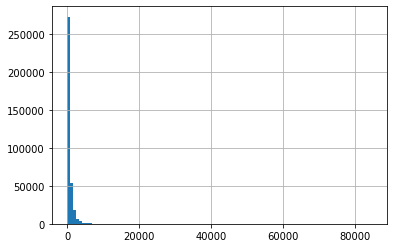

In [28]:
visits['session_duration_sec'].hist(bins = 100)

Распределение ненормальное, поэтому нам следует расчитать моду.

In [29]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Средняя продожительность сессии - 643 секунды. Но чаще всего пользователям хватает одной минуты.


<font color=#008000> 2.4 Как часто люди возвращаются? </font>

Что бы это узнать мы рассчитаем показатель Retention Rate (англ. «коэффициент удержания»).

Сначала мы создаём таблицу 'first_session_month', включающую в себя первые сессии для каждого пользователя по месяцам, и объединяем её с таблицей 'visits' по колонке 'uid'. Получившуюся таблицу сохраняем в переменной 'retention'.

In [30]:
first_session_month = visits.groupby(['uid'])['session_date'].min()
first_session_month.name = 'first_session_month'
retention = visits.join(first_session_month, on = 'uid')

Получим месяц первой сессии, и сохраним его в колонке 'first_session_month'.

In [31]:
retention['first_session_month'] = retention['first_session_month'].astype('datetime64[M]')

In [32]:
retention['session_month'] = retention['session_start'].astype('datetime64[M]')

Теперь расчитаем liftime пользователя в рамках каждой когорты.

In [33]:
retention['cohort_lifetime'] = retention['session_month'] - retention['first_session_month']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'M')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый месяц. Получившиеся данные сохраним в cohorts.

In [34]:
cohorts = (retention.groupby(['first_session_month', 'cohort_lifetime'])
                    .agg({'uid': 'nunique'})
                    .reset_index()
            )

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц.

In [35]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid': 'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте, и посчитаем Retention Rate, разделив количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте.

In [36]:
cohorts = cohorts.merge(initial_users_count, on = 'first_session_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу.

In [37]:
retention_pivot = cohorts.pivot_table(index = 'first_session_month', columns = 'cohort_lifetime',
                                          values = 'retention', aggfunc = 'sum')

Построим тепловую карту.

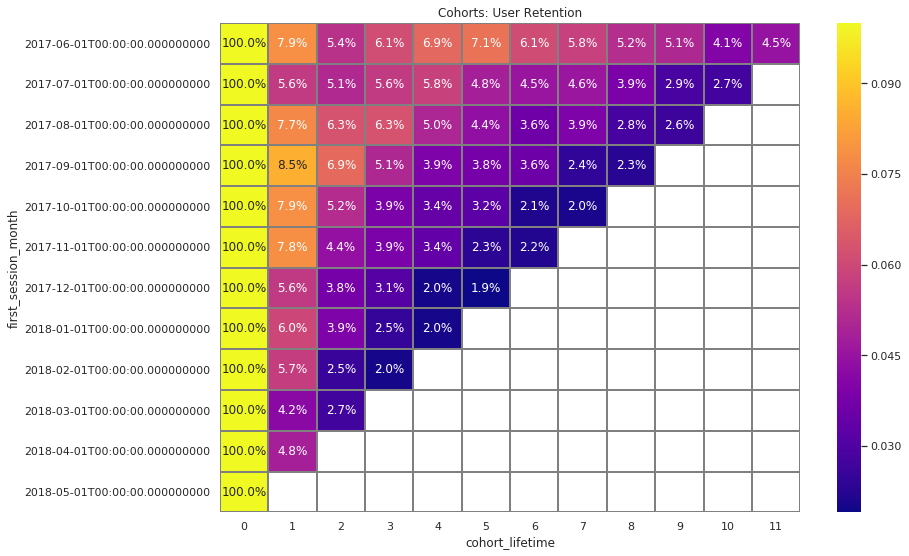

In [38]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot = True, fmt = '.1%', cmap = 'plasma', vmax = 0.10, linewidths=1, linecolor = 'gray');

Retention Rate довольно низкий. Во второй месяц в среднем возвращается 7% пользователей. Причём с каждой новой когортой этот показатель уменьшается. Лидером по Retention Rate является самая первая когорта, пришедшая в июне 2017 года.


<font color=#008000> 2.5 Когда люди начинают покупать? </font>

Нам нужно найти длительность промежутка времени между посещением сайта и покупкой.

Сначала мы сгруппируем данные в таблице visits по пользователям и их первому посещению.

In [39]:
first_visit = visits.groupby('uid')[['session_start']].min().reset_index()
first_visit.columns = ['uid', 'first_session']
first_visit.head()

,uid,first_session
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Теперь проделаем тоже самое с таблицей orders, сгруппируя по пользователям и их первой покупке.

In [40]:
first_purchase = orders.groupby('uid')[['purchase_date']].min().reset_index()
first_purchase.columns = ['uid', 'first_purchase_date']
first_purchase.head()

,uid,first_purchase_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Теперь сведйм две таблицы по id пользователей.

In [41]:
buy_time = first_visit.merge(first_purchase, on = 'uid')
buy_time.head()

,uid,first_session,first_purchase_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Теперь посчитаем разницу в минутах между первой сессией и первой покупкой, и добавм её в колонку 'buy_time'.

In [42]:
buy_time['buy_time'] = ((buy_time['first_purchase_date'] - buy_time['first_session']) / np.timedelta64(1, 'm')).round(1)
buy_time.head()

,uid,first_session,first_purchase_date,buy_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


Теперь сгруппируем данные в таблице по каждому пользователю и временем, которое им понадобилось для совершения первой покупки.

In [43]:
buy_time_to_hist = buy_time.groupby('uid')[['buy_time']].min()
buy_time_to_hist.head()

,buy_time
uid,
313578113262317,154022.0
1575281904278712,0.0
2429014661409475,79.0
2464366381792757,1184.0
2551852515556206,0.0


Для большей наглядности мы построим гистограмму. Перед этим мы проверим данные на выбросы.

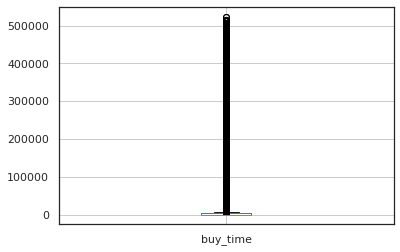

In [44]:
buy_time_to_hist.plot(kind = 'box', grid = True)

Выбросов слишком много. Поставим ограничение в 100 минут.

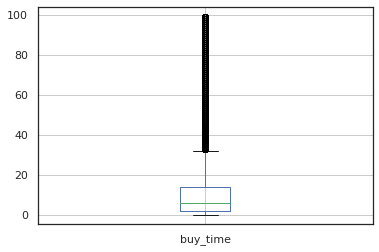

In [45]:
buy_time_to_hist.query('buy_time < 100').plot(kind = 'box', grid = True)

Выбросы начинаются примерно с 30 минут. Теперь построим гистограмму.

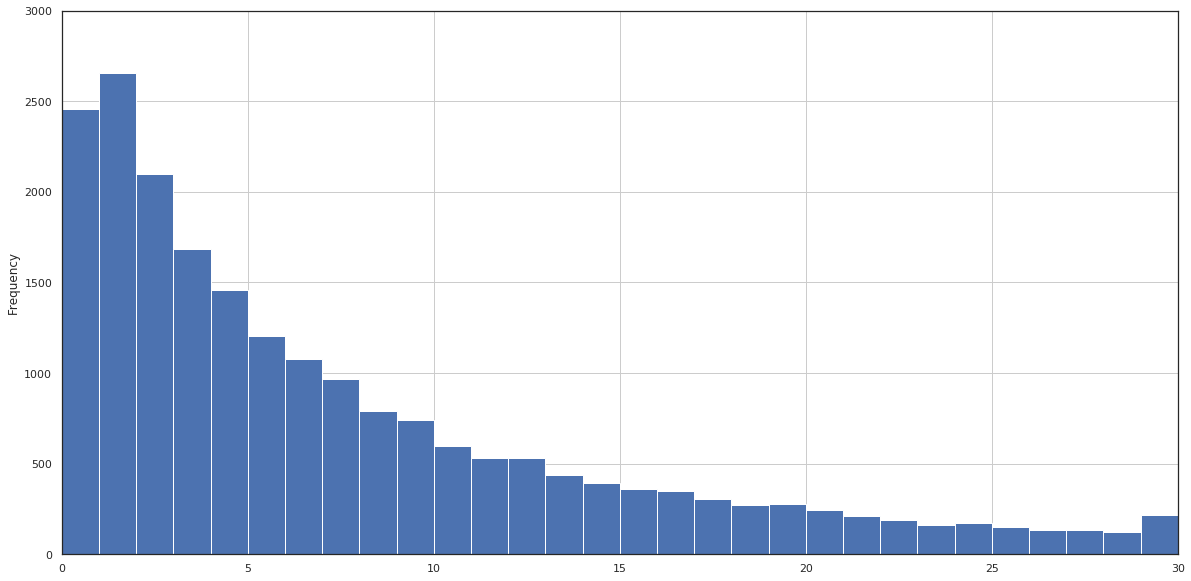

In [46]:
buy_time_to_hist.query('buy_time <= 30').plot(kind = 'hist', bins = 30, xlim = (0, 30), ylim = (0, 3000), figsize = (20, 10), grid = True, legend = False)

Большенству пользователей хватает 5 минут для совершения своей первой покупки .


<font color=#008000> 2.6 Сколько раз покупают за период? </font>

Сначала нам нужно сгруппировать данные в таблице orders по пользователям, и найти их первые покупки.

In [47]:
first_orders_date = orders.groupby('uid')[['purchase_date']].min().reset_index()
first_orders_date.columns = ['uid', 'first_purchase_date']

In [48]:
first_orders_date.head()

,uid,first_purchase_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [49]:
how_often_they_order = orders.merge(first_orders_date, on = 'uid')
how_often_they_order['purchase_date'] = how_often_they_order['purchase_date'].astype('datetime64[M]')
how_often_they_order['first_purchase_date'] = how_often_they_order['first_purchase_date'].astype('datetime64[M]')
how_often_they_order.head()

,purchase_date,revenue,uid,first_purchase_date
0,2017-06-01,17.00,10329302124590727494,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01
2,2017-06-01,0.37,17903680561304213844,2017-06-01
3,2017-06-01,0.55,16109239769442553005,2017-06-01
4,2017-06-01,0.37,14200605875248379450,2017-06-01


Расчитаем lifetime пользователей в рамках каждой когорты.

In [50]:
how_often_they_order['cohort_lifetime'] = how_often_they_order['purchase_date'] - how_often_they_order['first_purchase_date']
how_often_they_order['cohort_lifetime'] = how_often_they_order['cohort_lifetime'] / np.timedelta64(1,'M')
how_often_they_order['cohort_lifetime'] = how_often_they_order['cohort_lifetime'].round().astype('int')
how_often_they_order.head(10)

,purchase_date,revenue,uid,first_purchase_date,cohort_lifetime
0,2017-06-01,17.00,10329302124590727494,2017-06-01,0
1,2017-06-01,0.55,11627257723692907447,2017-06-01,0
2,2017-06-01,0.37,17903680561304213844,2017-06-01,0
3,2017-06-01,0.55,16109239769442553005,2017-06-01,0
4,2017-06-01,0.37,14200605875248379450,2017-06-01,0
5,2017-06-01,0.18,10402394430196413321,2017-06-01,0
6,2017-06-01,1.83,12464626743129688638,2017-06-01,0
7,2017-06-01,7.33,12464626743129688638,2017-06-01,0
8,2017-06-01,1.22,3644482766749211722,2017-06-01,0
9,2017-06-01,0.85,3644482766749211722,2017-06-01,0


Сгруппируем данные по когорте и lifetime.

In [51]:
how_often_they_order_by_cohorts = (how_often_they_order.groupby(['first_purchase_date', 'cohort_lifetime'])
                                    .agg({'purchase_date': 'count', 'uid': 'nunique'}))
how_often_they_order_by_cohorts.head(30)

purchase_date   uid
first_purchase_date cohort_lifetime                     
2017-06-01          0                         2354  2023
                    1                          177    61
                    2                          174    50
                    3                          226    54
                    4                          292    88
                    5                          218    67
                    6                          276    62
                    7                          174    47
                    8                          212    58
                    9                          153    45
                    10                          96    45
                    11                          86    53
2017-07-01          0                         2186  1923
                    1                          100    52
                    2                          120    57
                    3                          104    64
                    4                           72    49
                    5                           82    38
                    6                           61    36
                    7                           50    39
                    8                           58    42
                    9                           24    22
                    10                          53    26
2017-08-01          0                         1533  1370
                    1                          108    58
                    2                          100    53
                    3                           81    44
                    4                           85    40
                    5                           62    32
                    6                           49    30

Добавим в таблицу колонку со средним количеством заказов на одного покупателя в месяц.

In [52]:
how_often_they_order_by_cohorts['amount_of_purchases_per_customer'] = (how_often_they_order_by_cohorts['purchase_date'] / 
                                                                       how_often_they_order_by_cohorts['uid'])
how_often_they_order_by_cohorts = how_often_they_order_by_cohorts.reset_index()
how_often_they_order_by_cohorts.head(10)

,first_purchase_date,cohort_lifetime,purchase_date,uid,amount_of_purchases_per_customer
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,61,2.901639
2,2017-06-01,2,174,50,3.480000
3,2017-06-01,3,226,54,4.185185
4,2017-06-01,4,292,88,3.318182
5,2017-06-01,5,218,67,3.253731
6,2017-06-01,6,276,62,4.451613
7,2017-06-01,7,174,47,3.702128
8,2017-06-01,8,212,58,3.655172
9,2017-06-01,9,153,45,3.400000


Построим сводную таблицу.

In [53]:
how_often_they_order_pivot = how_often_they_order_by_cohorts.pivot_table(index = 'first_purchase_date', 
                                                                         columns = 'cohort_lifetime',
                                                                         values = 'amount_of_purchases_per_customer')
how_often_they_order_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим heatmap по таблице how_often_they_order_pivot.

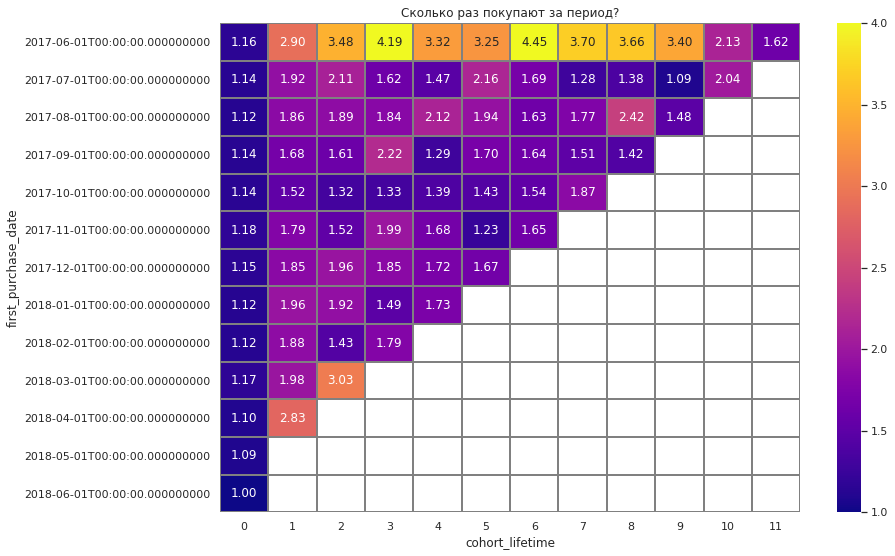

In [54]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('Сколько раз покупают за период?')
sns.heatmap(how_often_they_order_pivot, annot = True, fmt = '.2F', cmap = 'plasma', vmax = 4, linewidths=1, linecolor = 'gray');

Лидером по количеству покупок является 1-я когорта.

Также можно заметить, что в первый месяц пользователи редко совершают больше одной покупки.

Резкий скачёк в количестве покупок показывают мартовская и апрельская когорты.


<font color=#008000> 2.7 Какой средний чек? </font>

Для начала нам нужно сгруппировать данные из таблицы orders по когорте first_purchase_date и месяцу совершения заказа.

In [55]:
average_order_value = orders.merge(first_orders_date, on = 'uid')
average_order_value['first_purchase_date'] = average_order_value['first_purchase_date'].astype('datetime64[M]')
average_order_value['purchase_date'] = average_order_value['purchase_date'].astype('datetime64[M]')

average_order_value['purchase_date'] = average_order_value['purchase_date'].astype('datetime64[M]')
average_order_value['first_purchase_date'] = average_order_value['first_purchase_date'].astype('datetime64[M]')

average_order_value['cohort_lifetime'] = average_order_value['purchase_date'] - average_order_value['first_purchase_date']
average_order_value['cohort_lifetime'] = average_order_value['cohort_lifetime'] / np.timedelta64(1,'M')
average_order_value['cohort_lifetime'] = average_order_value['cohort_lifetime'].round().astype('int')

average_order_value_by_cohorts = average_order_value.groupby(['first_purchase_date','cohort_lifetime']).agg({'revenue' : 'sum', 'uid' : 'count'}).reset_index()
average_order_value_by_cohorts.head(10)

,first_purchase_date,cohort_lifetime,revenue,uid
0,2017-06-01,0,9557.49,2354
1,2017-06-01,1,981.82,177
2,2017-06-01,2,885.34,174
3,2017-06-01,3,1931.30,226
4,2017-06-01,4,2068.58,292
5,2017-06-01,5,1487.92,218
6,2017-06-01,6,1922.74,276
7,2017-06-01,7,1176.56,174
8,2017-06-01,8,1119.15,212
9,2017-06-01,9,1225.51,153


Добавим колонку со средним чеком покупателя, разделив колонку ravenue на uid.

In [56]:
average_order_value_by_cohorts['revenue_per_customer'] = (average_order_value_by_cohorts['revenue'] /
                                                         average_order_value_by_cohorts['uid'])

Теперь построим сводную таблицу изменения среднего чека по когортам.

In [57]:
average_order_value_by_cohorts_pivot = average_order_value_by_cohorts.pivot_table(index = 'first_purchase_date', columns = 'cohort_lifetime',
                                           values = 'revenue_per_customer', aggfunc = 'mean')
average_order_value_by_cohorts_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,4.060106,5.547006,5.088161,8.545575,7.084178,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,5.287123,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,4.715479,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN,NaN
2017-09-01,4.967109,13.171187,8.351056,62.570244,15.430448,15.321835,16.767130,11.206607,7.785574,NaN,NaN,NaN
2017-10-01,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN,NaN,NaN,NaN
2017-11-01,4.370717,4.103955,4.474670,6.284976,4.441471,3.726780,4.598235,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.110746,4.226741,20.072772,26.084358,15.948488,14.111048,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.687417,4.438482,6.454969,7.524844,2.711282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.706266,4.576486,3.453735,3.867143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим heatmap.

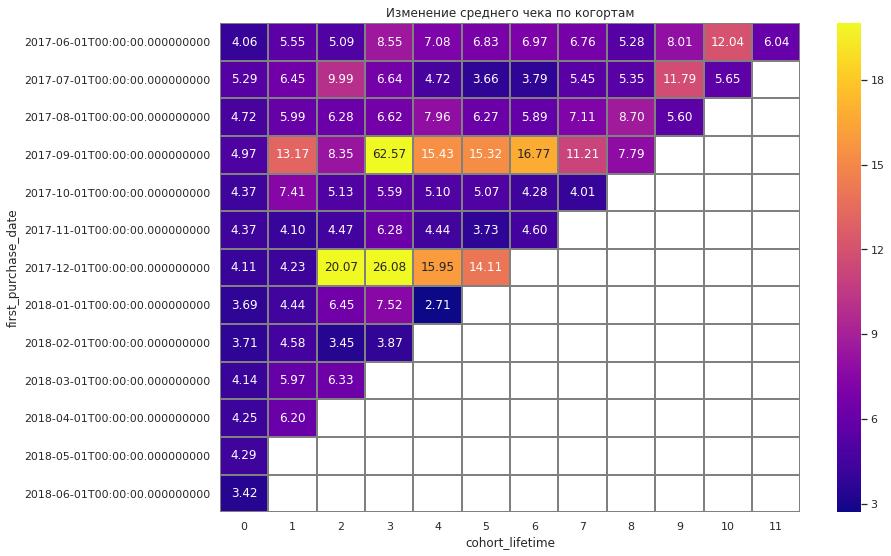

In [58]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('Изменение среднего чека по когортам')
sns.heatmap(average_order_value_by_cohorts_pivot, annot = True, fmt = '.2F', cmap = 'plasma', vmax = 20, linewidths=1, linecolor = 'gray');

Сильно выделяются сентябрьская когорта на 3й месяц, и декабрьская когорта на 2й и 3й месяц: средний чек значительно превышает норму. Следует изучить поведение этих когорт.


<font color=#008000> 2.8 Сколько денег приносят? (LTV) </font>

"LTV" - lifetime value, или итогорая сумма денег, которую один клиент в среднем приносит со всех своих покупок.

Следует заметить, что для нахождения LTV нам нужно знать маржинальность. Нам её не предоставили, поэтому будет определять LTV с маржинальностью 80%.

In [59]:
margin_rate = 0.8

Сначала посчитаем количество уникальных покупателей в каждой когорте.

In [60]:
first_orders = orders.groupby('uid').agg({'purchase_date': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_purchase_date']
first_orders['first_purchase_date'] = first_orders['first_purchase_date'].astype('datetime64[M]')

cohort_sizes = first_orders.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']
cohort_sizes.head()

,first_purchase_date,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Построим таблицу с когортным отчётом.

In [61]:
orders_first_month = orders.merge(first_orders, on = 'uid')
orders_first_month['purchase_date'] = orders_first_month['purchase_date'].astype('datetime64[M]')
cohorts = orders_first_month.groupby(['first_purchase_date', 'purchase_date']).agg({'revenue': 'sum'}).reset_index()
cohorts

,first_purchase_date,purchase_date,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


Построим сводную таблицу в строках которой будет месяц когорты, с столбцах — её возраст, а в значениях — средний LTV. 

In [62]:
LTV = cohort_sizes.merge(cohorts, on = 'first_purchase_date')

LTV['gp'] = LTV['revenue'] * margin_rate
LTV['age'] = (LTV['purchase_date'] - LTV['first_purchase_date']) / np.timedelta64(1, 'M')
LTV['age'] = LTV['age'].round().astype('int')

LTV['ltv'] = LTV['gp'] / LTV['n_buyers']

result = LTV.pivot_table(
    index = 'first_purchase_date', 
    columns = 'age', 
    values = 'ltv', 
    aggfunc = 'mean')

result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,3.779531,0.388263,0.350110,0.763737,0.818025,0.588401,0.760352,0.465273,0.442570,0.484631,0.457008,0.205485
2017-07-01,4.808175,0.268168,0.498825,0.287180,0.141433,0.124838,0.096166,0.113456,0.128986,0.117716,0.124539,NaN
2017-08-01,4.221215,0.377594,0.366785,0.313022,0.395241,0.226832,0.168531,0.324006,0.233769,0.150382,NaN,NaN
2017-09-01,4.515623,0.894069,0.416744,3.180634,0.320446,0.517654,0.561286,0.194520,0.147205,NaN,NaN,NaN
2017-10-01,4.002986,0.428610,0.153115,0.125716,0.121248,0.096289,0.067853,0.092376,NaN,NaN,NaN,NaN
2017-11-01,4.123746,0.319386,0.159645,0.259962,0.118410,0.043103,0.091942,NaN,NaN,NaN,NaN,NaN
2017-12-01,3.790553,0.208299,0.740078,0.852220,0.250344,0.270438,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.308509,0.235807,0.243425,0.114222,0.050158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.325590,0.222620,0.062812,0.059315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим Heatmap.

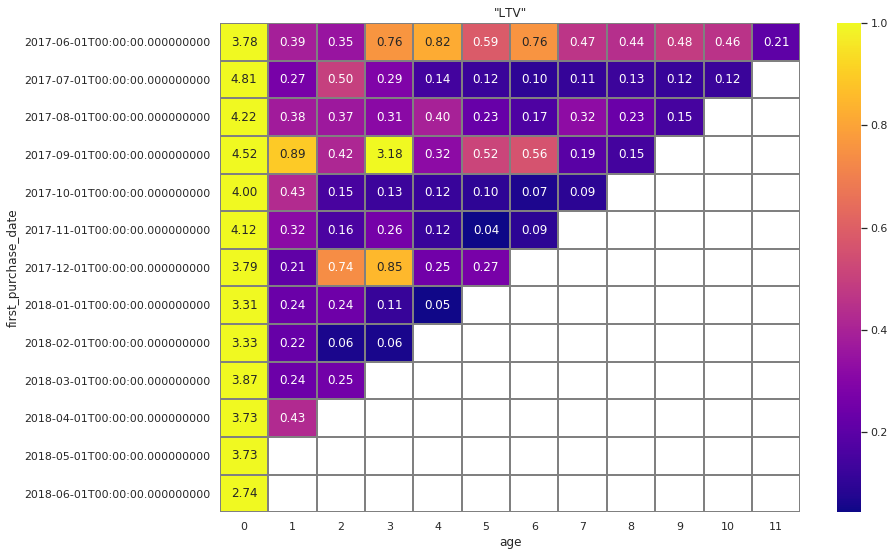

In [63]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('"LTV"')
sns.heatmap(result, annot = True, fmt = '.2F', cmap = 'plasma', vmax = 1, linewidths=1, linecolor = 'gray');

Самая первая когорта показывает наивысшее значение LTV. Также следует обратить внимание на сентябрьскую когорту: в 3м месяце их LTV аномально высокий.


<font color=#008000> 2.9 Сколько денег потратили? Всего / на каждый источник / по времени </font>



Чтобы найти общую сумму затрат мы воспользуемся простым методом .sum()

In [64]:
print('Затраты на маркетинг за всё время:', costs['costs'].sum())

Затраты на маркетинг за всё время: 329131.62


Теперь посчитаем маркетинговые затраты на каждый рекламный источник.

In [65]:
costs_grouped = costs.groupby('source_id').agg({'costs': 'sum'})
costs_grouped.head()

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10


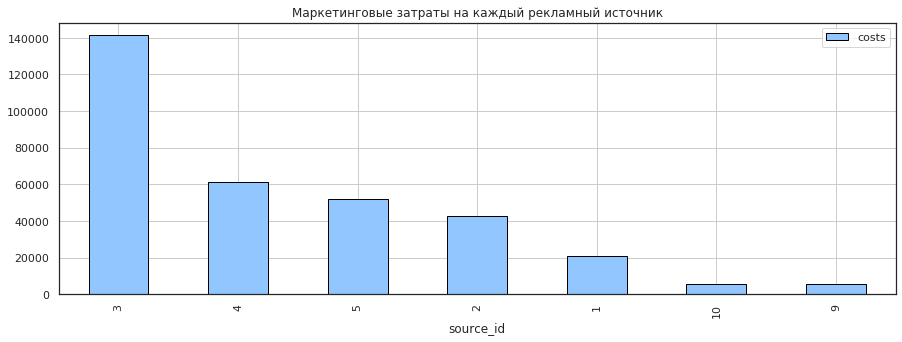

In [66]:
plt.style.use('seaborn-pastel')
costs_grouped.sort_values(by = 'costs', ascending = False).plot(kind = 'bar',
         figsize = (15,5),
         title = 'Маркетинговые затраты на каждый рекламный источник',
         ec = 'black',
         grid = True,
         legend = True)

Лидером по затратам является 3й источник. Далее идут 4й, 5й и 2й источники, с затратами от 40000 до 60000.


Теперь посчитаем маркетинговые затраты по времени.

In [67]:
costs_by_source = (costs.groupby(['source_id', 'date'])['costs']
                        .sum()
                        .reset_index()
                    )
costs_by_source['date'] = costs_by_source['date'].astype('datetime64[M]')
costs_by_source = costs_by_source.groupby(['source_id', 'date'])['costs'].sum().reset_index()

In [69]:
costs_by_source.head(10)

,source_id,date,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
5,1,2017-11-01,2445.16
6,1,2017-12-01,2341.20
7,1,2018-01-01,2186.18
8,1,2018-02-01,2204.48
9,1,2018-03-01,1893.09


Создадим dataframe для каждого маркетингового источника.

In [70]:
filtered_source_1_data = costs_by_source.query('source_id == 1').reset_index(drop = True)
filtered_source_2_data = costs_by_source.query('source_id == 2').reset_index(drop = True)
filtered_source_3_data = costs_by_source.query('source_id == 3').reset_index(drop = True)
filtered_source_4_data = costs_by_source.query('source_id == 4').reset_index(drop = True)
filtered_source_5_data = costs_by_source.query('source_id == 5').reset_index(drop = True)
filtered_source_9_data = costs_by_source.query('source_id == 9').reset_index(drop = True)
filtered_source_10_data = costs_by_source.query('source_id == 10').reset_index(drop = True)

Построим график для кажлого источника.

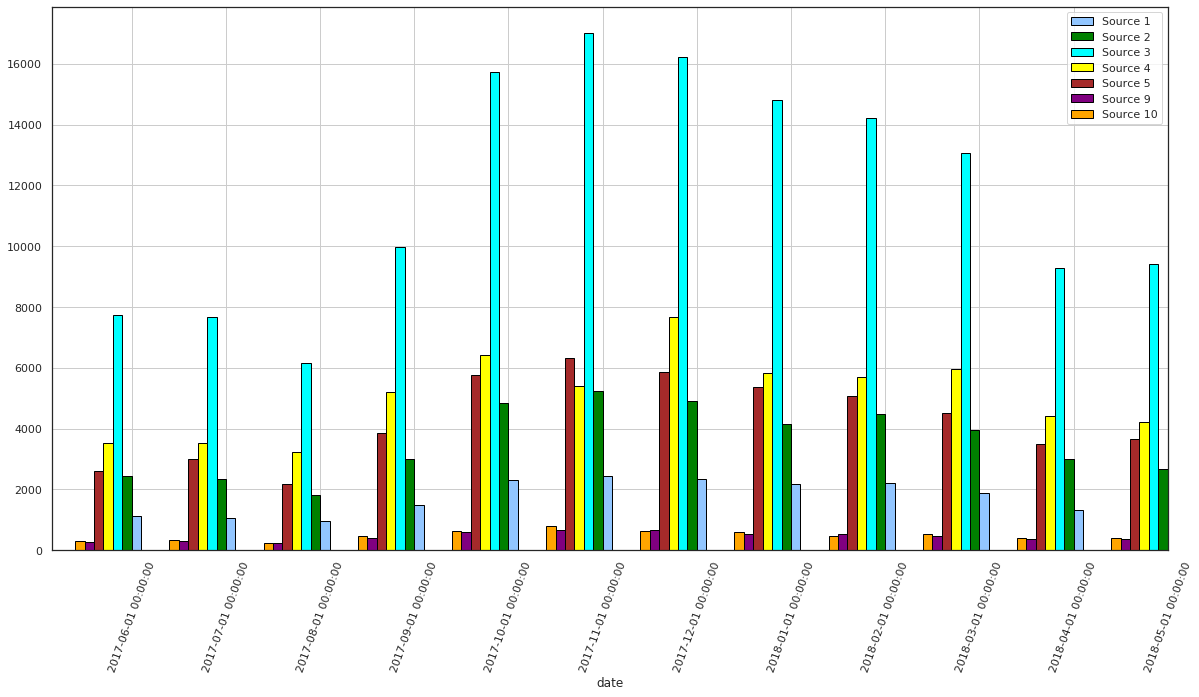

In [71]:
ax = plt.gca()

plot1 = filtered_source_1_data
plot1.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, position = 0)

plot2 = filtered_source_2_data
plot2.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'green', rot = 70, grid = True, position = 1)

plot3 = filtered_source_3_data
plot3.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'cyan', rot = 70, grid = True, position = 2)

plot4 = filtered_source_4_data
plot4.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'yellow', rot = 70, grid = True, position = 3)

plot5 = filtered_source_5_data
plot5.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'brown', rot = 70, grid = True, position = 4)

plot6 = filtered_source_9_data
plot6.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'purple', rot = 70, grid = True, position = 5)

plot7 = filtered_source_10_data
plot7.plot(x = 'date', y = 'costs', kind = 'bar', figsize = (20,10), ec = 'black', ax = ax, width = 0.1, color = 'orange', rot = 70, grid = True, position = 6)

ax.legend(['Source 1', 'Source 2', 'Source 3', 'Source 4', 'Source 5', 'Source 9', 'Source 10'])

Маркетинговые затраты на все источники резко возрасли в октябре 2017 года.


<font color=#008000> 2.10 Сколько стоило привлечение одного покупателя из каждого источника? </font>

Сначала мы найдём самый первый канал, по которому пользователь пришёл на сайт. Получившиеся данные сохраним в переменной first_source_per_user.

In [72]:
first_source_per_user = visits.sort_values(by = 'session_start').groupby('uid').agg({'source_id': 'first'})
first_source_per_user.head()

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


Теперь объединим таблицы first_source_per_user и orders по 'uid', и сгруппируем данные по 'source_id', выделяя уникальные 'uid'.

In [73]:
client_per_source = orders.merge(first_source_per_user, on = 'uid')
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})
client_per_source.head(10)

,uid
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


Теперь у нас есть данные по количеству привлечённых каждым источником покупателей. Объединим таблицы costs_grouped и client_per_source.

In [74]:
clients_and_costs_per_source = pd.merge(costs_grouped, client_per_source, on = 'source_id')
clients_and_costs_per_source.head(10)

,costs,uid
source_id,,
1,20833.27,2899
2,42806.04,3506
3,141321.63,10473
4,61073.60,10296
5,51757.10,6931
9,5517.49,1088
10,5822.49,1329


Добавим в clients_and_costs_per_source колонку со средней стоимостью привлечения покупателя.

In [76]:
clients_and_costs_per_source['avg_cost_per_client'] = ((clients_and_costs_per_source['costs'] / 
                                                       clients_and_costs_per_source['uid'])
                                                       .round(3)
                                                       )
clients_and_costs_per_source['avg_cost_per_client'].sort_values(ascending = False).to_frame()

,avg_cost_per_client
source_id,
3,13.494
2,12.209
5,7.467
1,7.186
4,5.932
9,5.071
10,4.381


Ожидаемо, что самым дорогим оказался покупатель из 3го источника. За ним идут покупатели из 2го и 5го.


<font color=#008000> 2.11 На сколько окупились расходы? (ROI) или (ROMI) </font>

ROI, или "return on investment", это возрат на инвестиции. Но в нашей ситуации лучше считать метрику ROMI - return on marketing investments.

Что бы найти эту метрику, нам нужно вычесть поделить валовую прибыль на на затраченные инвестиции.

In [77]:
revenue_per_client = orders.groupby('uid').agg({'revenue': 'sum'})
revenue_per_client.head()

,revenue
uid,
313578113262317,0.55
1575281904278712,3.05
2429014661409475,73.33
2464366381792757,2.44
2551852515556206,10.99


In [88]:
client_first_source_with_revenue = pd.merge(first_source_per_user, revenue_per_client, on = 'uid')

In [89]:
revenue_per_source = client_first_source_with_revenue.groupby('source_id').agg({'revenue' : 'sum'})
revenue_per_source.head(10)

,revenue
source_id,
1,31090.55
2,46923.61
3,54511.24
4,56696.83
5,52624.02
7,1.22
9,5759.40
10,4450.33


In [90]:
clients_costs_revenue_per_source = pd.merge(clients_and_costs_per_source, revenue_per_source, on = 'source_id')

Теперь добавим колонку ROI для каждого источника. Поставим условную маржинальность в 80%.

In [85]:
clients_costs_revenue_per_source['ROMI'] = (((clients_costs_revenue_per_source['revenue'] * 0.8)) /
                                           clients_costs_revenue_per_source['costs']) * 100
clients_costs_revenue_per_source.head(10)

,costs,uid,avg_cost_per_client,revenue,ROMI
source_id,,,,,
1,20833.27,2899,7.186,31090.55,119.388075
2,42806.04,3506,12.209,46923.61,87.695307
3,141321.63,10473,13.494,54511.24,30.857974
4,61073.60,10296,5.932,56696.83,74.266891
5,51757.10,6931,7.467,52624.02,81.339982
9,5517.49,1088,5.071,5759.40,83.507537
10,5822.49,1329,4.381,4450.33,61.146760


Единственный окупившийся маркетинговый источник - 1й. Самая низкая окупаемость у 3го, самого дорогого по затратам источника.


### Вывод

Маркетологам следует сократить расходы на 3й источник. На протяжении всего периода наблюдений он лидировал по затратам, и это дало свои плоды: 3й источник является лидером по покупателям и среднему чеку. Но окупился он только на 30%.


Маркетологам следует увеличить затраты на 1й, 2й, 5й и 9й источники.
